Notebook testing the use of `timeaverage` when some of the integrations are blanked (i.e., some integrations are all NaNs).

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

from dysh import util
from dysh.fits.gbtfitsload import GBTFITSLoad

In [4]:
# Point it to the testdata directory.
proj_path = f"{util.get_project_testdata()}/TGBT21A_501_11/NGC2782_blanks/"
data_path = f"{proj_path}/NGC2782.raw.vegas.A.fits"

In [5]:
sdf = GBTFITSLoad(data_path)

In [6]:
sdf.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,156,NGC2782,2543.139777,OnOff,1,1.617185,1.420406,5,2,2,1,286.482849,57.301769
1,157,NGC2782,2543.139777,OnOff,2,1.617185,1.420406,5,2,2,1,286.132025,58.249648


Try to calibrate and timeaverage the `OnOff` scan.

In [19]:
ps_sb = sdf.getps([156])
ps_sb[0]._calibrated.shape

FILE  /home/sandboxes/psalas/Dysh/dysh/testdata/TGBT21A_501_11/NGC2782_blanks//NGC2782.raw.vegas.A.fits
FILE  /home/sandboxes/psalas/Dysh/dysh/testdata/TGBT21A_501_11/NGC2782_blanks//NGC2782.raw.vegas.A.fits


/home/sandboxes/psalas/Dysh/dysh/src/dysh/spectra/core.py:364: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


(2, 32768)

In [20]:
s=ps_sb.data[0].timeaverage(None)

In [21]:
ta = ps_sb.timeaverage()

In [22]:
ps_sb.data[0]._calibrated.shape

(2, 32768)

The time average is all NaNs because one, or more, of the integrations were blanked.

In [25]:
all_nan = np.isnan(ta[0].flux.value).sum() == len(ta[0].flux)
print(f"Are all the values NaN? {all_nan}")
assert ~all_nan

Are all the values NaN? False


Let's try to find the blanked integrations. Most likely these are the last integrations of a scan.

In [30]:
for i in range(len(ps_sb[0]._calibrated)):
    if np.isnan(ps_sb[0].calibrated(i).flux.value).sum() == len(ta[0].flux):
        print(f"Integration {i} is all NaNs")

Integration 1 is all NaNs


In [27]:
ps_sb[0].calibrated(0).meta["EXPOSURE"] - ta[0].meta["EXPOSURE"]

0.0

In [29]:
abs(ps_sb[0].calibrated(0).meta["TSYS"] - ta[0].meta["TSYS"]) < 5e-16

True

In [31]:
np.all((ps_sb[0].calibrated(0).flux.value - ta[0].flux.value) < 2e-19)

True

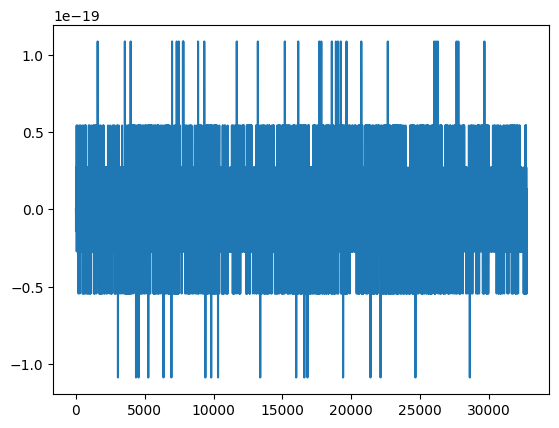

In [18]:
plt.figure()
plt.plot(ps_sb[0].calibrated(0).flux.value - ta[0].flux.value)

In [21]:
ps_sb[0].calibrated(1)

<Spectrum1D(flux=<Quantity [nan, nan, nan, ..., nan, nan, nan] K>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0
    doppler_rest=1420405751.7 Hz
    doppler_convention=optical)
  [1.42006309e+09, 1.42006238e+09, 1.42006166e+09, ..., 1.39662774e+09,
   1.39662703e+09, 1.39662631e+09] Hz>)>